<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/17-representation-learning-and-generative-learning-using-autoencoders-and-gans/5_feature_extraction_using_denoising_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature extraction using Denoising Autoencoders

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called latent representations or codings, without any supervision (i.e., the training set is unlabeled). These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction, especially for visualization purposes. 

Autoencoders also act as feature detectors, and they can be used for unsupervised pretraining of deep neural networks. Lastly, some autoencoders are generative models: they are capable of randomly generating new data that looks very similar to the training data.

For example, you could train an autoencoder on pictures of faces, and it would then be able to generate new faces. However, the generated images are usually fuzzy and not entirely realistic.

In contrast, faces generated by generative adversarial networks (GANs) are now so convincing that it is hard to believe that the people they represent do not exist. You can judge so for yourself by visiting https://thispersondoesnotexist.com/, a website that shows faces generated by a recent GAN architecture called StyleGAN (you can also check out https://thisrentaldoesnotexist.com/ to see some generated Airbnb bedrooms).

GANs are now widely used for super resolution (increasing the resolution of
an image), colorization, powerful image editing (e.g., replacing photo bombers with realistic background), turning a simple sketch into a photorealistic image, predicting the next frames in a video, augmenting a dataset (to train other models), generating other types of data (such as text, audio, and time series), identifying the weaknesses in other models and strengthening them, and more.

Autoencoders and GANs are both unsupervised, they both learn dense representations, they can both be used as generative models, and they have many similar applications.

However, they work very differently:

* Autoencoders simply learn to copy their inputs to their outputs. This may sound like a trivial task, but we will see that constraining the network in various ways can make it rather difficult. For example, you can limit the size of the latent representations, or you can add noise to the inputs and train the network to recover the original inputs. These constraints prevent the autoencoder from trivially copying the inputs directly to the outputs, which forces it to learn efficient ways of representing the data. In short, the codings are byproducts of the autoencoder learning the identity function under some constraints.

* GANs are composed of two neural networks: a generator that tries to generate data that looks similar to the training data, and a discriminator that tries to tell real data from fake data. This architecture is very original in Deep Learning in that the generator and the discriminator compete against each other during training: the generator is often compared to a criminal trying to make realistic counterfeit money, while the discriminator is like the police investigator trying to tell real money from fake.

We will start by exploring in more depth how autoencoders work and how to use them for dimensionality reduction, feature extraction, unsupervised pretraining, or as generative models. This will naturally lead us to GANs. We will start by building a simple GAN to generate fake images, but we will see that training is often quite difficult.



## Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

TensorFlow 2.x selected.


A couple utility functions to plot grayscale 28x28 image:

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

## Denoising Autoencoders using Gaussian noise

Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. 

This idea has been around since the 1980s (e.g., it is mentioned in Yann LeCun’s 1987 master’s thesis). In a [2008 paper](https://www.iro.umontreal.ca/~vincentp/Publications/denoising_autoencoders_tr1316.pdf), Pascal Vincent et al. showed that autoencoders could also be used for feature extraction. In a [2010 paper](http://jmlr.csail.mit.edu/papers/v11/vincent10a), Vincent et al. introduced stacked denoising autoencoders.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/denoising-autoencoders.png?raw=1' width='800'/>

The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched-off inputs, just like in dropout.

The implementation is straightforward: it is a regular stacked autoencoder with an additional Dropout layer applied to the encoder’s inputs (or you could use a GaussianNoise layer instead). Recall that the Dropout layer is only active during training (and so is the GaussianNoise layer):

Let's load MNIST dataset.

In [0]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


Here is a simple convolutional autoencoder for Fashion MNIST:

In [0]:
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# split the autoencoder model into two submodels: the encoder and the decoder.
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),    # encoder takes 28 × 28–pixel grayscale images, flattens them to vector of size 784
    keras.layers.GaussianNoise(0.2),    
    keras.layers.Dense(100, activation='selu'),    
    keras.layers.Dense(30, activation='selu')
])

denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),  
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

denoising_autoencoder = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_autoencoder.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

# Finally, we train the model using X_train as both the inputs and the targets
# and similarly, we use X_valid as both the validation inputs and targets
history = denoising_autoencoder.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 129us/sample - loss: 0.3513 - rounded_accuracy: 0.8763 - val_loss: 0.3179 - val_rounded_accuracy: 0.9066
Epoch 2/10
55000/55000 [==============================] - 5s 92us/sample - loss: 0.3126 - rounded_accuracy: 0.9093 - val_loss: 0.3079 - val_rounded_accuracy: 0.9165
Epoch 3/10
55000/55000 [==============================] - 5s 92us/sample - loss: 0.3058 - rounded_accuracy: 0.9150 - val_loss: 0.3030 - val_rounded_accuracy: 0.9191
Epoch 4/10
55000/55000 [==============================] - 5s 91us/sample - loss: 0.3021 - rounded_accuracy: 0.9183 - val_loss: 0.2999 - val_rounded_accuracy: 0.9232
Epoch 5/10
55000/55000 [==============================] - 5s 92us/sample - loss: 0.2991 - rounded_accuracy: 0.9209 - val_loss: 0.2969 - val_rounded_accuracy: 0.9253
Epoch 6/10
55000/55000 [==============================] - 5s 92us/sample - loss: 0.2968 - rounded_accuracy: 0.9230 - val_loss

In [0]:
denoising_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [0]:
denoising_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


### Visualizing the Reconstructions

One way to ensure that an autoencoder is properly trained is to compare the inputs and the outputs: the differences should not be too significant. 

Let’s plot a few images from the validation set, as well as their reconstructions:

In [0]:
def show_reconstructions(model, images=X_valid, n_images=5):
  reconstructions = model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])

Let's see a few noisy images (with half the pixels turned off), and the
images reconstructed by the GaussianNoise based denoising autoencoder.

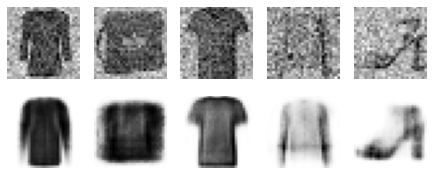

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_autoencoder, noise(X_valid, training=True))

## Denoising Autoencoders using Dropout

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# split the autoencoder model into two submodels: the encoder and the decoder.
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),    # encoder takes 28 × 28–pixel grayscale images, flattens them to vector of size 784
    keras.layers.Dropout(0.5),    
    keras.layers.Dense(100, activation='selu'),    
    keras.layers.Dense(30, activation='selu')
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),  
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

dropout_autoencoder = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_autoencoder.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

# Finally, we train the model using X_train as both the inputs and the targets
# and similarly, we use X_valid as both the validation inputs and targets
history = dropout_autoencoder.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 101us/sample - loss: 0.3572 - rounded_accuracy: 0.8703 - val_loss: 0.3193 - val_rounded_accuracy: 0.9052
Epoch 2/10
55000/55000 [==============================] - 5s 93us/sample - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3117 - val_rounded_accuracy: 0.9115
Epoch 3/10
55000/55000 [==============================] - 5s 94us/sample - loss: 0.3128 - rounded_accuracy: 0.9076 - val_loss: 0.3087 - val_rounded_accuracy: 0.9144
Epoch 4/10
55000/55000 [==============================] - 5s 92us/sample - loss: 0.3096 - rounded_accuracy: 0.9100 - val_loss: 0.3049 - val_rounded_accuracy: 0.9164
Epoch 5/10
55000/55000 [==============================] - 5s 93us/sample - loss: 0.3070 - rounded_accuracy: 0.9120 - val_loss: 0.3023 - val_rounded_accuracy: 0.9178
Epoch 6/10
55000/55000 [==============================] - 5s 91us/sample - loss: 0.3052 - rounded_accuracy: 0.9134 - val_loss

In [0]:
dropout_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [0]:
dropout_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


### Visualizing the Reconstructions

Let's see a few noisy images (with half the pixels turned off), and the images reconstructed by the dropout-based denoising autoencoder.

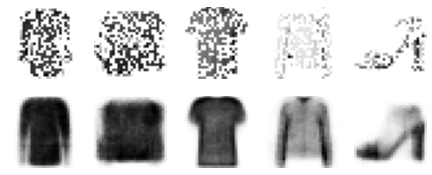

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_autoencoder, dropout(X_valid, training=True))

Notice how the autoencoder guesses details that are actually not in the input, such as the top of the white shirt (bottom row, fourth image). As you can see, not only can denoising autoencoders be used for data visualization or unsupervised pretraining, like the other autoencoders we’ve discussed so far, but they can also be used quite simply and efficiently to remove noise from images.

